## Vehicle Patterns in the Preserve

##### Context
This project aim to explore a dataset where events were captured by sensors at various locations within a Preserve in order to discover patterns in vehicle movements within the Preserve and to extract insights related to the significant reduction in the population of Rose-Crested Blue Pipits.

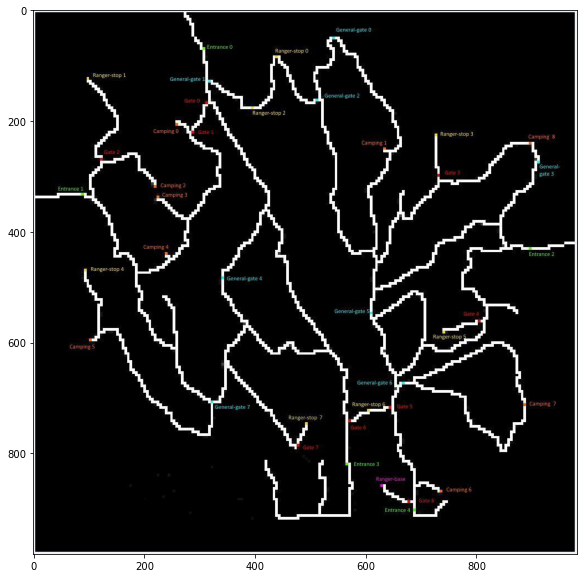

In [2]:
#Preserve Map
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10,10))
map=mpimg.imread('Lekagul Roadways labeled v2.jpg')
maplot=plt.imshow(map)

#### Traffic info
Traffic enters and exits the Preserve through official Entrances. There are campgrounds for day and overnight camping. Some roads are restricted to Preserve Rangers. Rangers use sensors to monitor traffic. Entry gates at the entrances issue entry tickets with RF-tags to track vehicles within the Preserve. Vehicles surrender these tickets when exiting, with exits also recorded.
When vehicles enter the Preserve, they must proceed through a gate and obtain a pass.  The gate categorizes vehicles as follows:
1.	2 axle car (or motorcycle)
2.	2 axle truck
3.	3 axle truck
4.	4 axle (and above) truck
5.	2 axle bus
6.	3 axle bus

There are vehicles designated with a "P" in their category, indicating they are park service vehicles with full access to the Preserve. Currently, these vehicles are 2 axle trucks labeled as "2P." The data is recorded by five types of sensors:

1. Entrances.  All vehicles pass through an Entrance when entering or leaving the Preserve. 
2.	General-gates.  All vehicles may pass through these gates.  These sensors provide valuable information for the Preserve Rangers trying to understand the flow of traffic through the Preserve. 
3.	Gates.  These are gates that prevent general traffic from passing.  Preserve Ranger vehicles have tags that allow them to pass through these gates to inspect or perform work on the roadway beyond.  
4.	Ranger-stops.  These sensors represent working areas for the Rangers, so you will often see a Ranger-stop sensor at the end of a road managed by a Gate.  Some Ranger-stops are in other locations however, so these sensors record all traffic passing by. 
5.	Camping.  These sensors record visitors to the Preserve camping areas.  Visitors pass by these entering and exiting a campground. 





#### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss
import itertools
import prophet

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error




#### Read in data & preparations

In [4]:
df = pd.read_csv('Lekagul Sensor Data.csv')
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in this sensor event data file.")

There are 171477 rows and 4 columns in this sensor event data file.


In [5]:
# How the data looks
df.head()

,Timestamp,car-id,car-type,gate-name
0,2015-05-01 00:43:28,20154301124328-262,4,entrance3
1,2015-05-01 01:03:48,20154301124328-262,4,general-gate1
2,2015-05-01 01:06:24,20154301124328-262,4,ranger-stop2
3,2015-05-01 01:09:25,20154301124328-262,4,ranger-stop0
4,2015-05-01 01:12:36,20154301124328-262,4,general-gate2


In [6]:
print(f'This dataset contains sensor event details from {df.Timestamp.min()} to {df.Timestamp.max()}.')

This dataset contains sensor event details from 2015-05-01 00:43:28 to 2016-05-31 23:56:06.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171477 entries, 0 to 171476
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Timestamp  171477 non-null  object
 1   car-id     171477 non-null  object
 2   car-type   171477 non-null  object
 3   gate-name  171477 non-null  object
dtypes: object(4)
memory usage: 5.2+ MB


In [8]:
df.describe()

,Timestamp,car-id,car-type,gate-name
count,171477,171477,171477,171477
unique,170298,18708,7,40
top,2015-07-31 12:00:02,20154519024544-322,1,general-gate7
freq,5,281,67698,16119


Few things:
- No missing values among the columns.
- They are all string type which need to be converted to proper types.
- A total of 18,708 unique vehicles have crossed 40 distinct gates within the Preserve, involving 7 unique car types.

In [9]:
#Data type converting
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['car-id'] = df['car-id'].astype('category')
df['car-type'] = df['car-type'].astype('category')
df['gate-name'] = df['gate-name'].astype('category')

In [10]:
#Set index
df['date']=df['Timestamp']
df = df.set_index('Timestamp')

In [11]:
# Time series features creation
df['day'] = df.index.date
df['dayOfWeek'] = df.index.day_of_week
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Week'] = df.index.isocalendar().week.astype(int)
df['Time'] = df.index.time

In [12]:
# set gate type
print(sorted(df['gate-name'].unique()))

['camping0', 'camping1', 'camping2', 'camping3', 'camping4', 'camping5', 'camping6', 'camping7', 'camping8', 'entrance0', 'entrance1', 'entrance2', 'entrance3', 'entrance4', 'gate0', 'gate1', 'gate2', 'gate3', 'gate4', 'gate5', 'gate6', 'gate7', 'gate8', 'general-gate0', 'general-gate1', 'general-gate2', 'general-gate3', 'general-gate4', 'general-gate5', 'general-gate6', 'general-gate7', 'ranger-base', 'ranger-stop0', 'ranger-stop1', 'ranger-stop2', 'ranger-stop3', 'ranger-stop4', 'ranger-stop5', 'ranger-stop6', 'ranger-stop7']


In [13]:
def gate_type(x):
    if 'camping' in x:
        return 'C', x[-1]
    elif 'entr' in x:
        return 'E', x[-1]
    elif x.startswith('general'):
        return 'General', x[-1]
    elif x.startswith('gate') or 'stop' in x:
        return 'R', x[-1]
    else:
        return 'R', 'B'
    
df['gate-type']=df['gate-name'].apply(lambda x: gate_type(x)[0])
df['gate-num']=df['gate-name'].apply(lambda x: gate_type(x)[1])
#df['gate-type'] = df['gate-type'].astype('category')

        

In [14]:
# Re-check df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 171477 entries, 2015-05-01 00:43:28 to 2016-05-31 23:56:06
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   car-id     171477 non-null  category      
 1   car-type   171477 non-null  category      
 2   gate-name  171477 non-null  category      
 3   date       171477 non-null  datetime64[ns]
 4   day        171477 non-null  object        
 5   dayOfWeek  171477 non-null  int64         
 6   Month      171477 non-null  int64         
 7   Year       171477 non-null  int64         
 8   Week       171477 non-null  int64         
 9   Time       171477 non-null  object        
 10  gate-type  171477 non-null  object        
 11  gate-num   171477 non-null  object        
dtypes: category(3), datetime64[ns](1), int64(4), object(4)
memory usage: 14.4+ MB


In [15]:
df.head()

,car-id,car-type,gate-name,date,day,dayOfWeek,Month,Year,Week,Time,gate-type,gate-num
Timestamp,,,,,,,,,,,,
2015-05-01 00:43:28,20154301124328-262,4,entrance3,2015-05-01 00:43:28,2015-05-01,4,5,2015,18,00:43:28,E,3
2015-05-01 01:03:48,20154301124328-262,4,general-gate1,2015-05-01 01:03:48,2015-05-01,4,5,2015,18,01:03:48,General,1
2015-05-01 01:06:24,20154301124328-262,4,ranger-stop2,2015-05-01 01:06:24,2015-05-01,4,5,2015,18,01:06:24,R,2
2015-05-01 01:09:25,20154301124328-262,4,ranger-stop0,2015-05-01 01:09:25,2015-05-01,4,5,2015,18,01:09:25,R,0
2015-05-01 01:12:36,20154301124328-262,4,general-gate2,2015-05-01 01:12:36,2015-05-01,4,5,2015,18,01:12:36,General,2


#### EDA and Visualization

In [16]:
# generate paths for each vehicle
path = df.copy()


In [17]:
def chunks(x):
    l=list(x)
    if 'E' in l:
        indices=[ind for ind, ele in enumerate(l) if ele == 'E']
        if len(indices)%2==0:
            return [' -> '.join(l[indices[i]:indices[i+1]+1]) for i in range(0,len(indices),2)]
        else:
            temp= [' -> '.join(l[indices[i]:indices[i+1]+1]) for i in range(0,len(indices)-1,2)]
            temp.append(' -> '.join(l[indices[-1]:]))
    else:
        return [' -> '.join(l)]

    

In [18]:
def car_type(x):
    return list(x)[0]

In [19]:
paths=path.groupby(['car-id']).agg({'gate-type': chunks,'car-type':car_type,'dayOfWeek':set})
paths.rename(columns={'gate-type':'path'},inplace=True)
paths=paths.explode('path')
#paths=paths.explode('dayOfWeek')
paths.head()


,path,car-type,dayOfWeek
car-id,,,
20150001010009-284,E -> General -> R -> R -> General -> General -...,3,"{2, 3}"
20150001050042-811,E -> General -> C -> C -> General -> E,1,"{1, 5}"
20150001060025-421,E -> General -> General -> R -> R -> General -> E,2,{1}
20150001070000-174,E -> General -> R -> R -> General -> General -...,1,{1}
20150001070006-104,E -> General -> R -> R -> General -> General -...,1,"{3, 5}"


In [20]:
print(f'There are {paths.path.nunique()} unique paths for traveling in the Preserve through the year')

There are 356 unique paths for traveling in the Preserve through the year


The popularity of travel breakdown by months(Rangers Vehicle excluded)

In [21]:
monthly_pop = path[path['gate-type']!='R'].groupby(['Year','Month']).agg({'car-id':'nunique'}).reset_index()
monthly_pop['date'] = pd.date_range('2015-05','2016-06',freq='M').strftime("%B %Y")
monthly_pop

,Year,Month,car-id,date
0,2015,5,1267,May 2015
1,2015,6,2814,June 2015
2,2015,7,4290,July 2015
3,2015,8,3642,August 2015
4,2015,9,2644,September 2015
5,2015,10,1001,October 2015
6,2015,11,379,November 2015
7,2015,12,228,December 2015
8,2016,1,232,January 2016
9,2016,2,493,February 2016


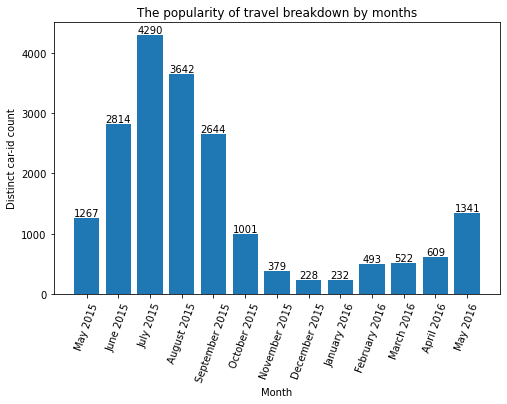

In [22]:
fig,ax=plt.subplots(figsize=(8,5))
ax.bar(monthly_pop.date, monthly_pop['car-id'])
ax.bar_label(ax.containers[0])
ax.set(xlabel='Month', ylabel='Distinct car-id count', title='The popularity of travel breakdown by months')
plt.xticks(rotation=70)

plt.show()

- Most people chose to travel the Preserve in the middle of the year begining from May and start to decrease from August and stay low until the next May.

In [23]:
gates_pop=path.groupby(['Year','Month','gate-type','gate-num']).agg({'car-id':'nunique'}).reset_index()
print(gates_pop)

     Year  Month gate-type gate-num  car-id
0    2015      5         C        0      36
1    2015      5         C        1       7
2    2015      5         C        2      56
3    2015      5         C        3      61
4    2015      5         C        4      49
..    ...    ...       ...      ...     ...
405  2016      5         R        5      69
406  2016      5         R        6      66
407  2016      5         R        7      24
408  2016      5         R        8      71
409  2016      5         R        B      71

[410 rows x 5 columns]


In [24]:
gates_pop['Month-Year']=gates_pop['Month'].astype(str)+'/'+gates_pop['Year'].astype(str)
gates_pop['gates']=gates_pop['gate-type']+gates_pop['gate-num']
gates_pop.head()

,Year,Month,gate-type,gate-num,car-id,Month-Year,gates
0,2015,5,C,0,36,5/2015,C0
1,2015,5,C,1,7,5/2015,C1
2,2015,5,C,2,56,5/2015,C2
3,2015,5,C,3,61,5/2015,C3
4,2015,5,C,4,49,5/2015,C4


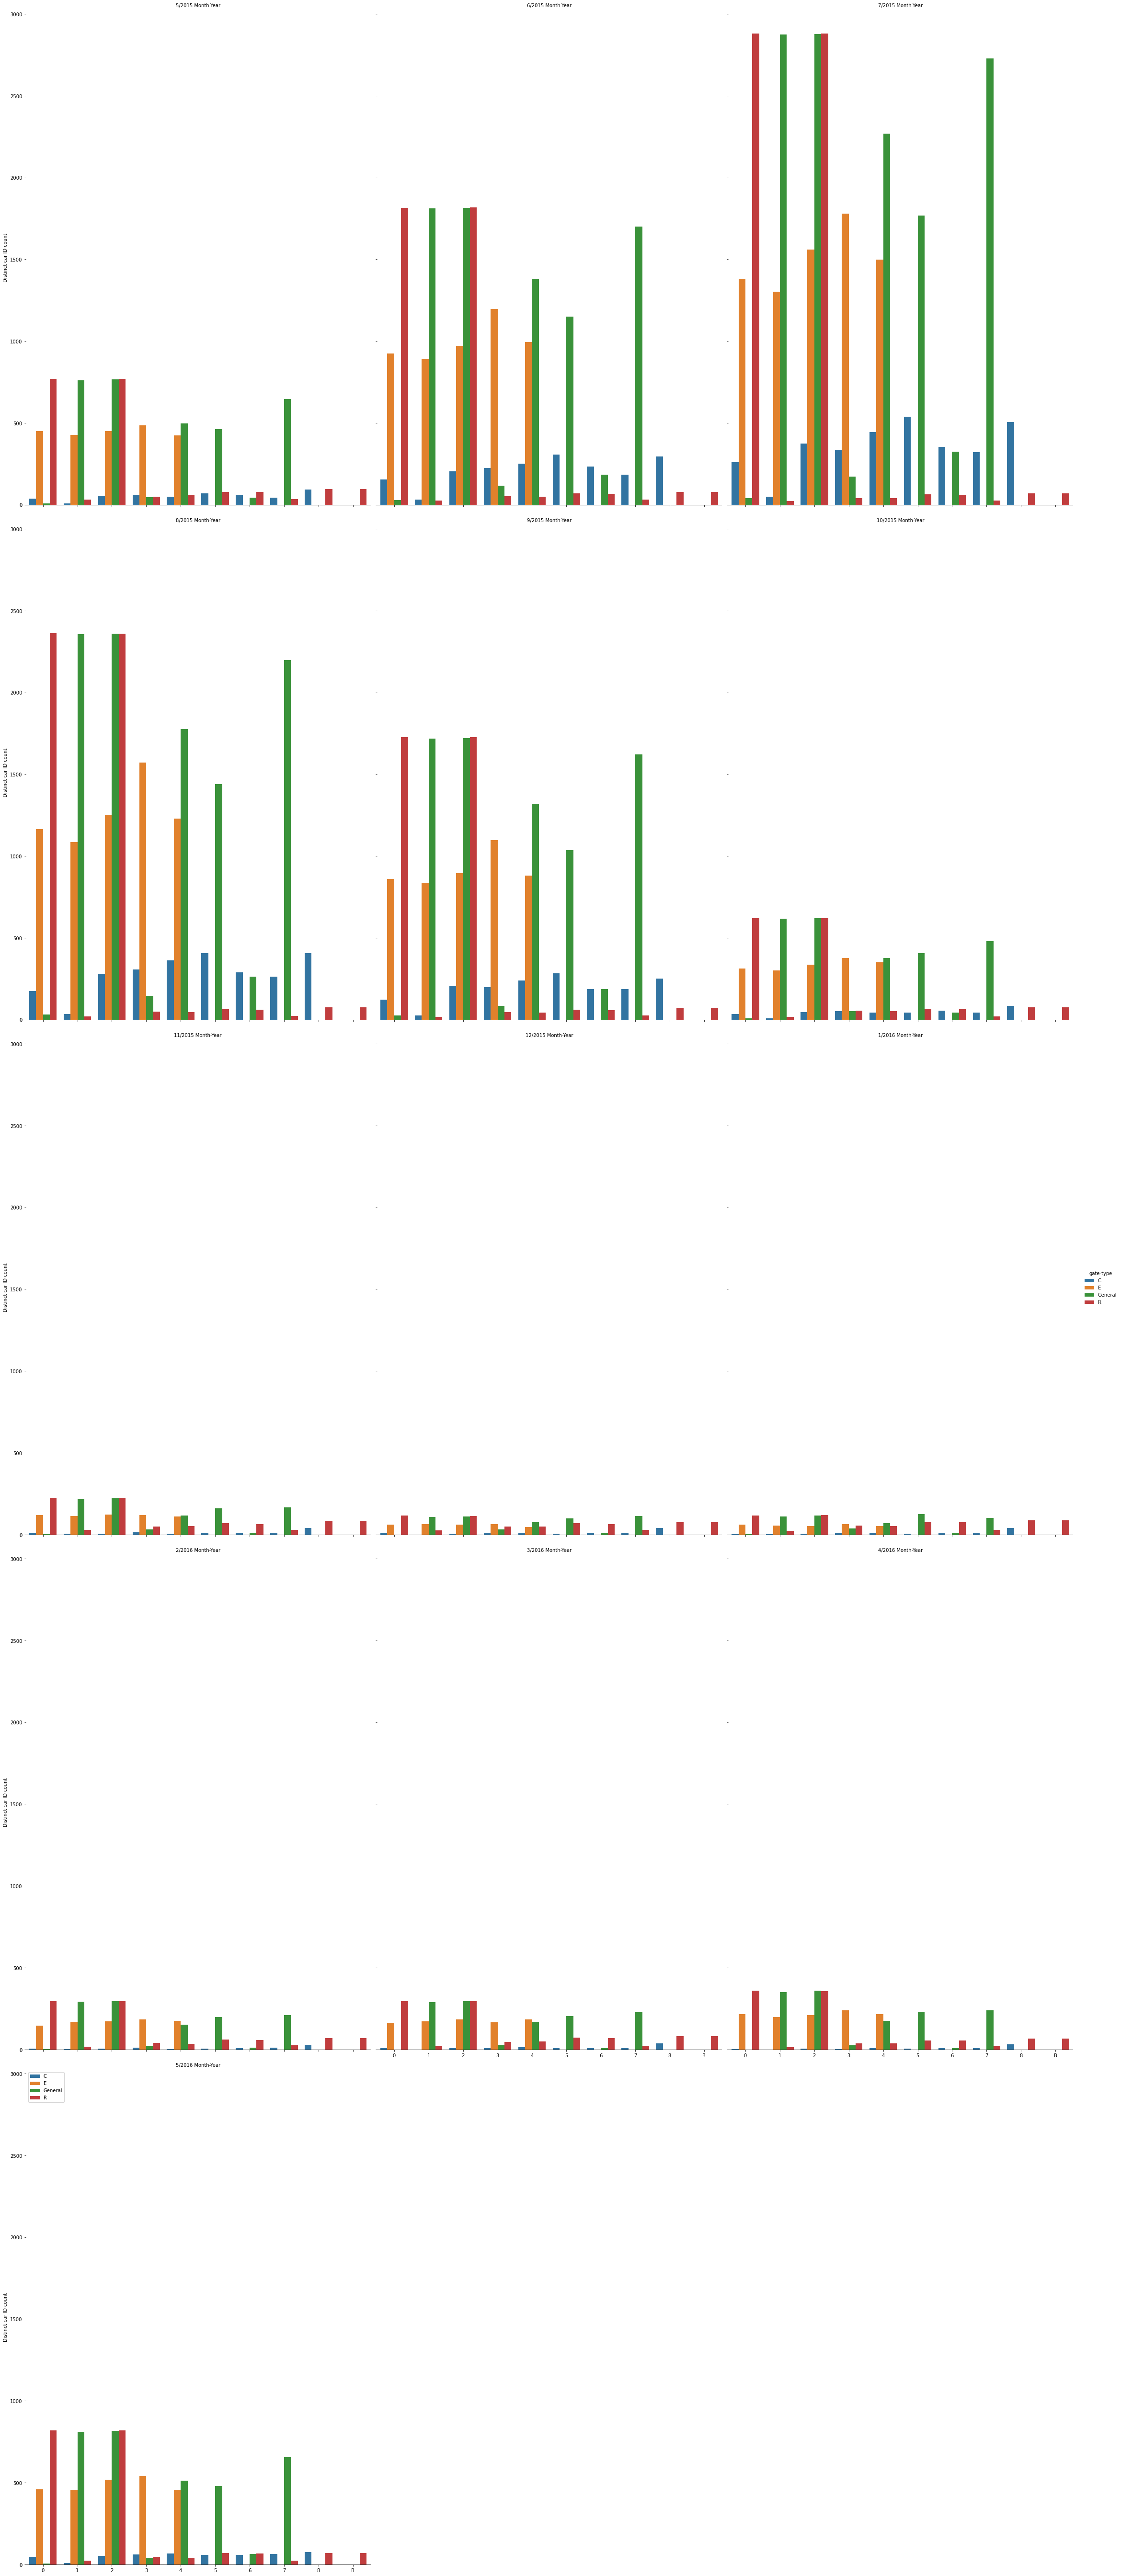

In [25]:
#Car volume by gate number through months
g = sns.catplot(
    data=gates_pop, x="gate-num", y="car-id", col="Month-Year", hue="gate-type", col_wrap=3,
    kind="bar", height=15, aspect=.7,
)
g.set_axis_labels("", "Distinct car ID count")
g.set_titles("{col_name} {col_var}")
g.despine(left=True)
plt.legend()

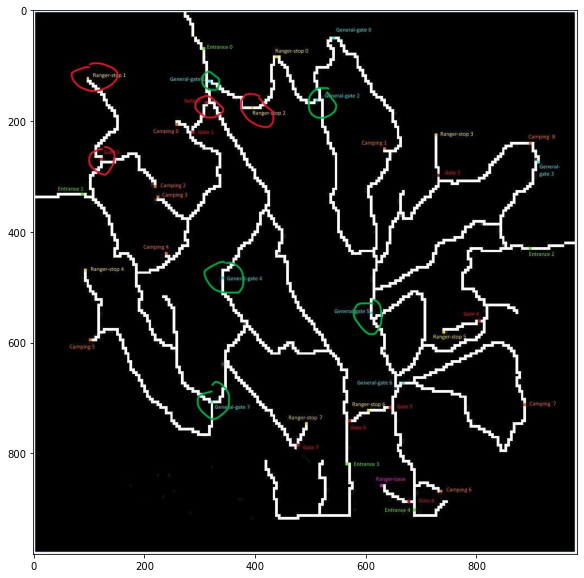

In [26]:
plt.figure(figsize=(10,10))
volume=mpimg.imread('Vehicle_volume.jpg')
vplot=plt.imshow(volume)

Findings:
- General gates have the most passed vehicles compare to entrances and camping areas, which makes sense, a vehicle can pass through several general gates before reaching the exit and without choosing camping.
- I'm suprised that the trend of the populairty that vehicles passing the gates are following the same pattern through months.
- I don't know if it's a safe assumption to make that, to complete the trips in the Preserve, the paths are constant, the count of vehicles passing one gate increases, all of the gate within the path increases as well, which also indicates that there was no significant changing on a particular gate to cause the reduction in a certain area.
- Entrance0,1,2,3,4, general1,2,4,5,7, ranger0,2 have the most vehicle volumes, it most likely happed in the north west of the Preserve. And it's really depending on where the birds's habitat are to decide if this is a factor caused the reduction.
- Now let's dig with paths.

#### Vehicle pattern through paths

In [27]:
a=paths['path'].value_counts().nlargest(6)


In [28]:
a.index

Index(['E -> General -> R -> R -> General -> E', 'E -> E',
       'E -> General -> C -> C -> General -> E',
       'E -> General -> General -> E',
       'E -> General -> R -> R -> General -> General -> E',
       'E -> General -> E'],
      dtype='object')

E -> General -> R -> R -> General -> E               1639
E -> E                                               1587
E -> General -> C -> C -> General -> E                952
E -> General -> General -> E                          850
E -> General -> R -> R -> General -> General -> E     764
E -> General -> E                                     759
Name: path, dtype: int64


<AxesSubplot:>

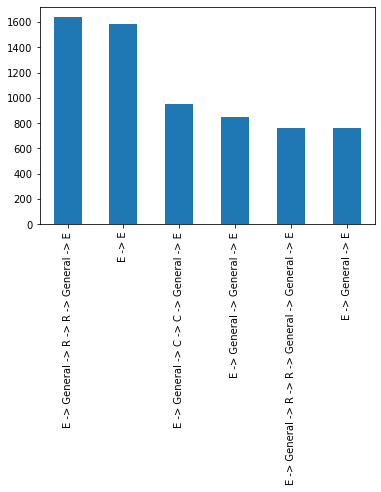

In [29]:
# top 6 paths
print(paths['path'].value_counts().iloc[:6])

(paths['path'].value_counts()).iloc[:6].plot(kind='bar')

In [30]:
pathByWk = paths.explode('dayOfWeek')
pathByWk=pathByWk[pathByWk['path'].isin(pathByWk['path'].value_counts().nlargest(10).index)]

In [31]:
pathByWk.head()

,path,car-type,dayOfWeek
car-id,,,
20150001050042-811,E -> General -> C -> C -> General -> E,1,1
20150001050042-811,E -> General -> C -> C -> General -> E,1,5
20150001060025-421,E -> General -> General -> R -> R -> General -> E,2,1
20150001070006-104,E -> General -> R -> R -> General -> General -...,1,3
20150001070006-104,E -> General -> R -> R -> General -> General -...,1,5


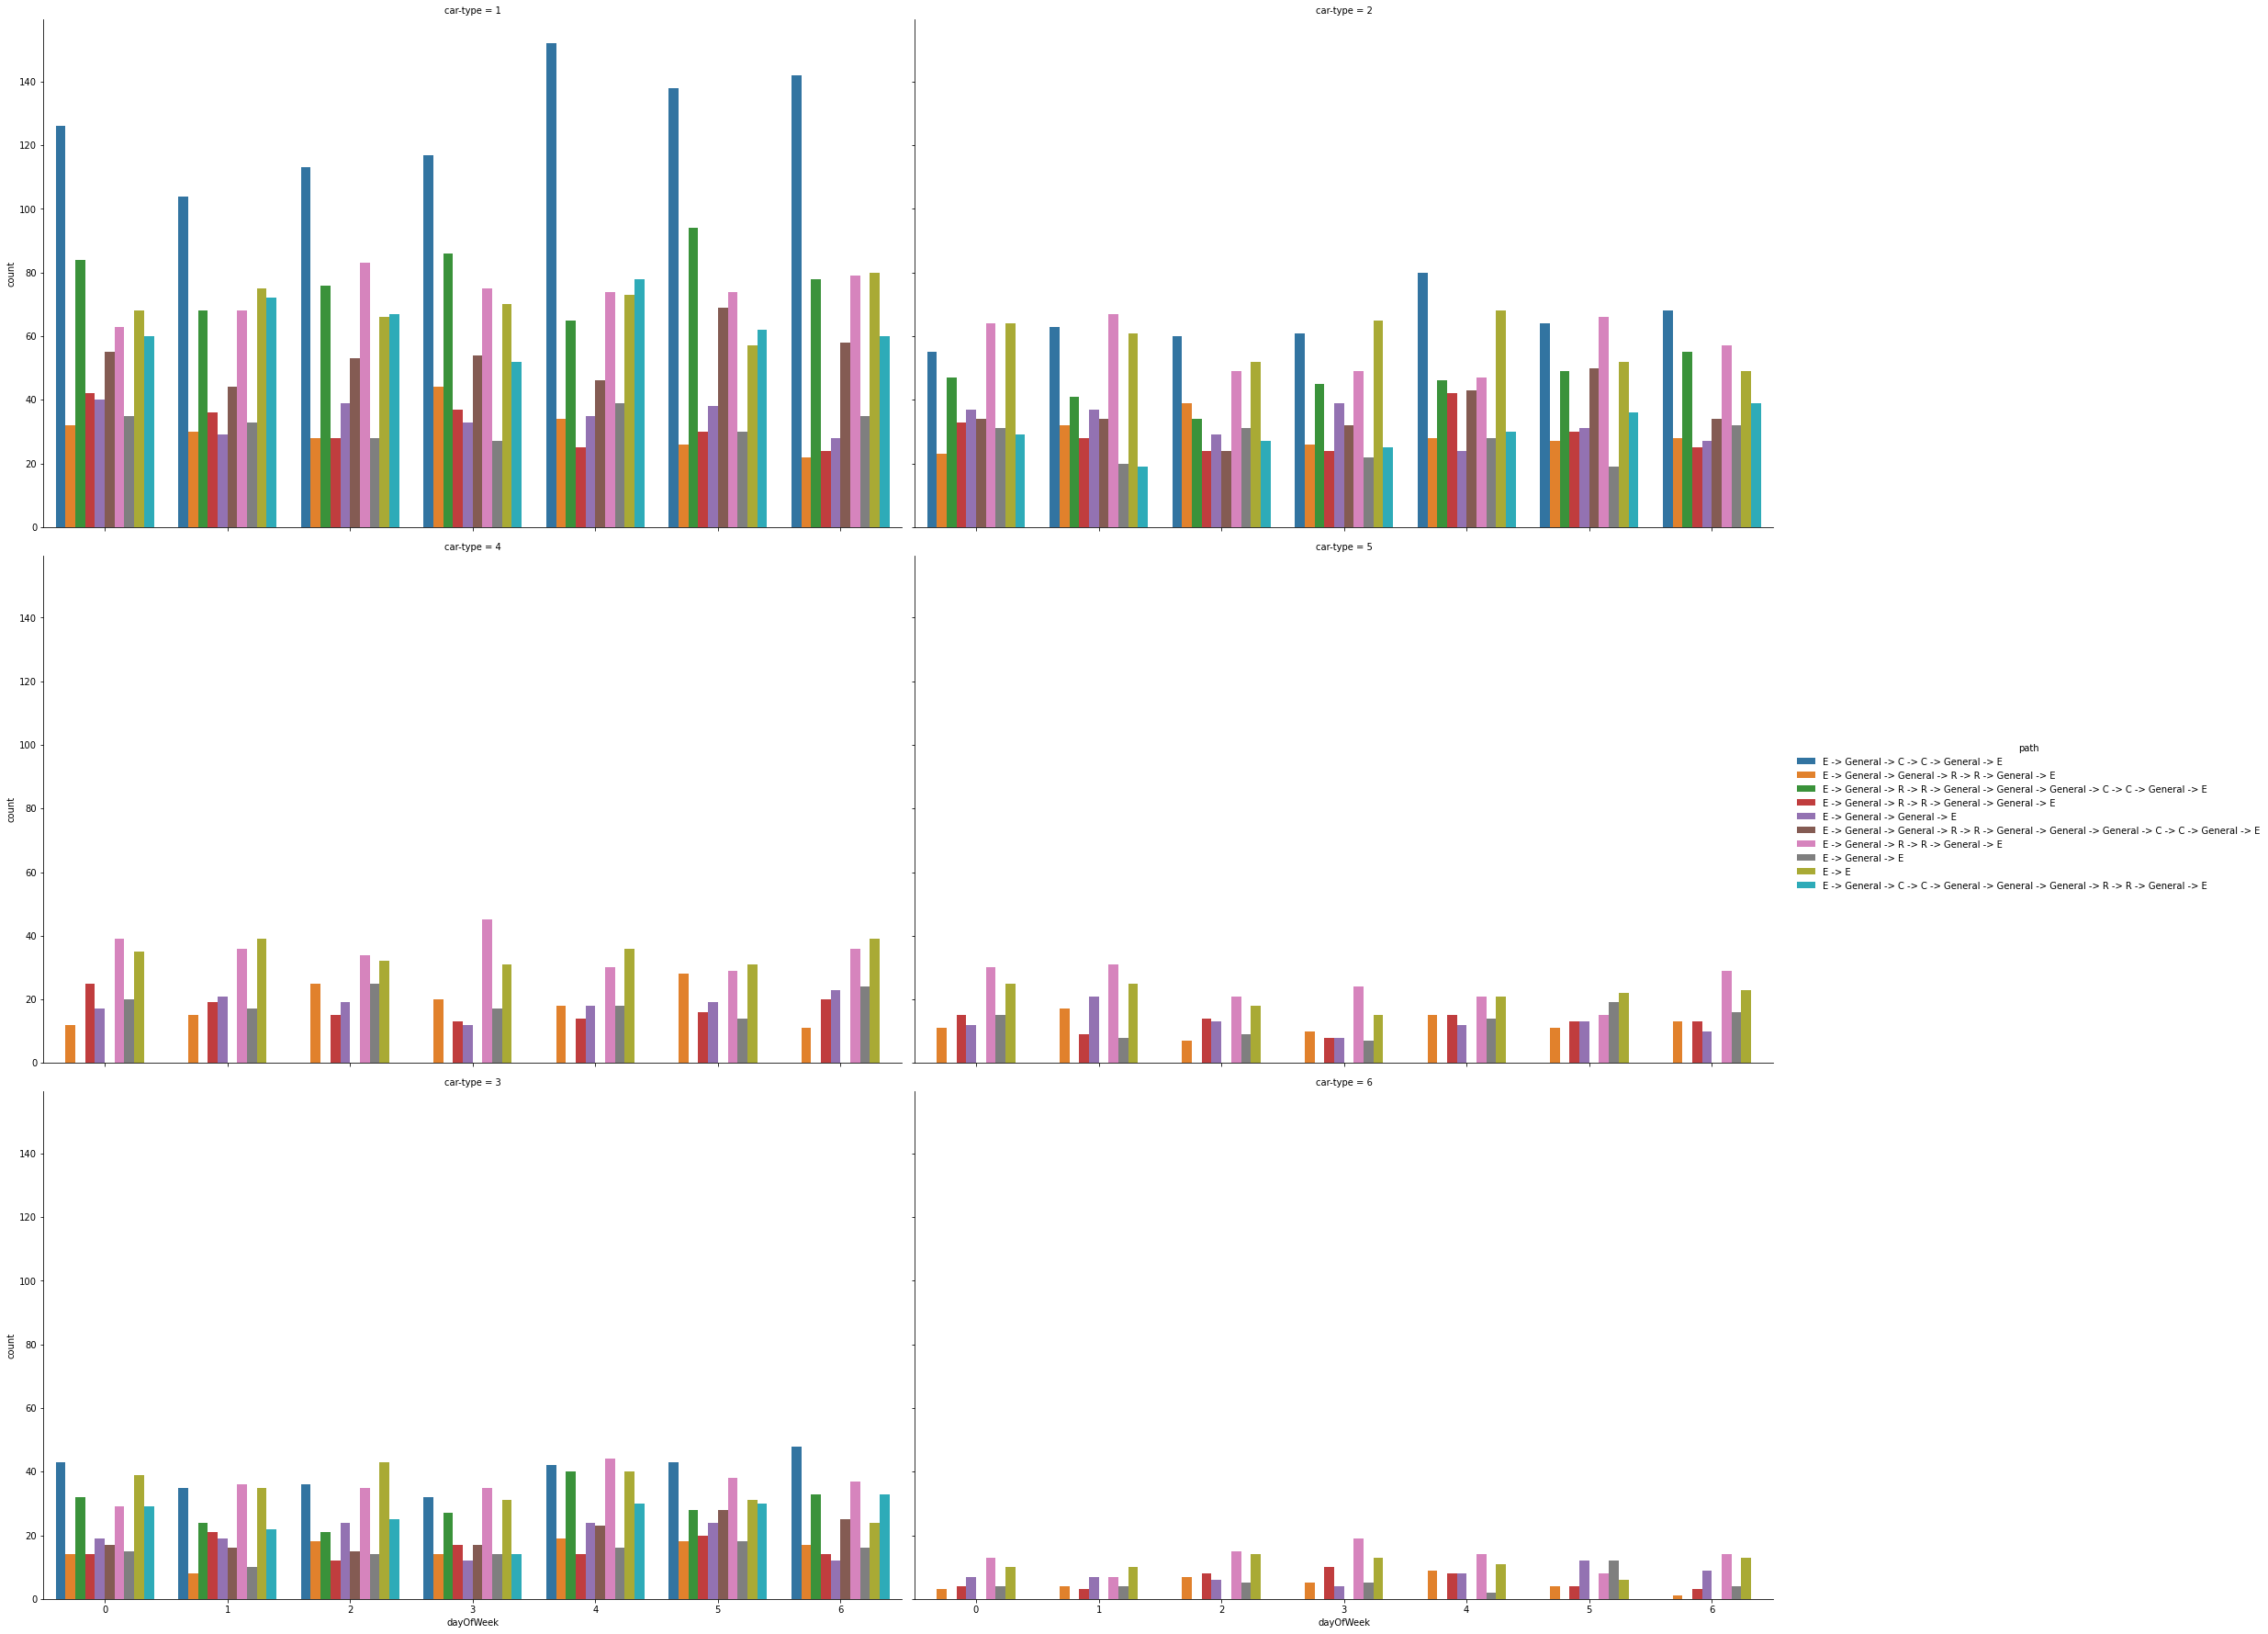

In [32]:
#car type count by days of week in top 10 paths
sns.catplot(data=pathByWk, x="dayOfWeek", hue="path",col='car-type',kind="count" ,col_wrap=2,height=8.27, aspect=13.7/8.27)

- Ranger Vehicle has the uniform pattern over each week, a ranger vehicle can be any car type.
- People are most likely stay camping from thursday to the end of the week, most of them drive car type 1, then 2 and 3.
- E->E seems like a weild pattern specially with car type 1 and 2.

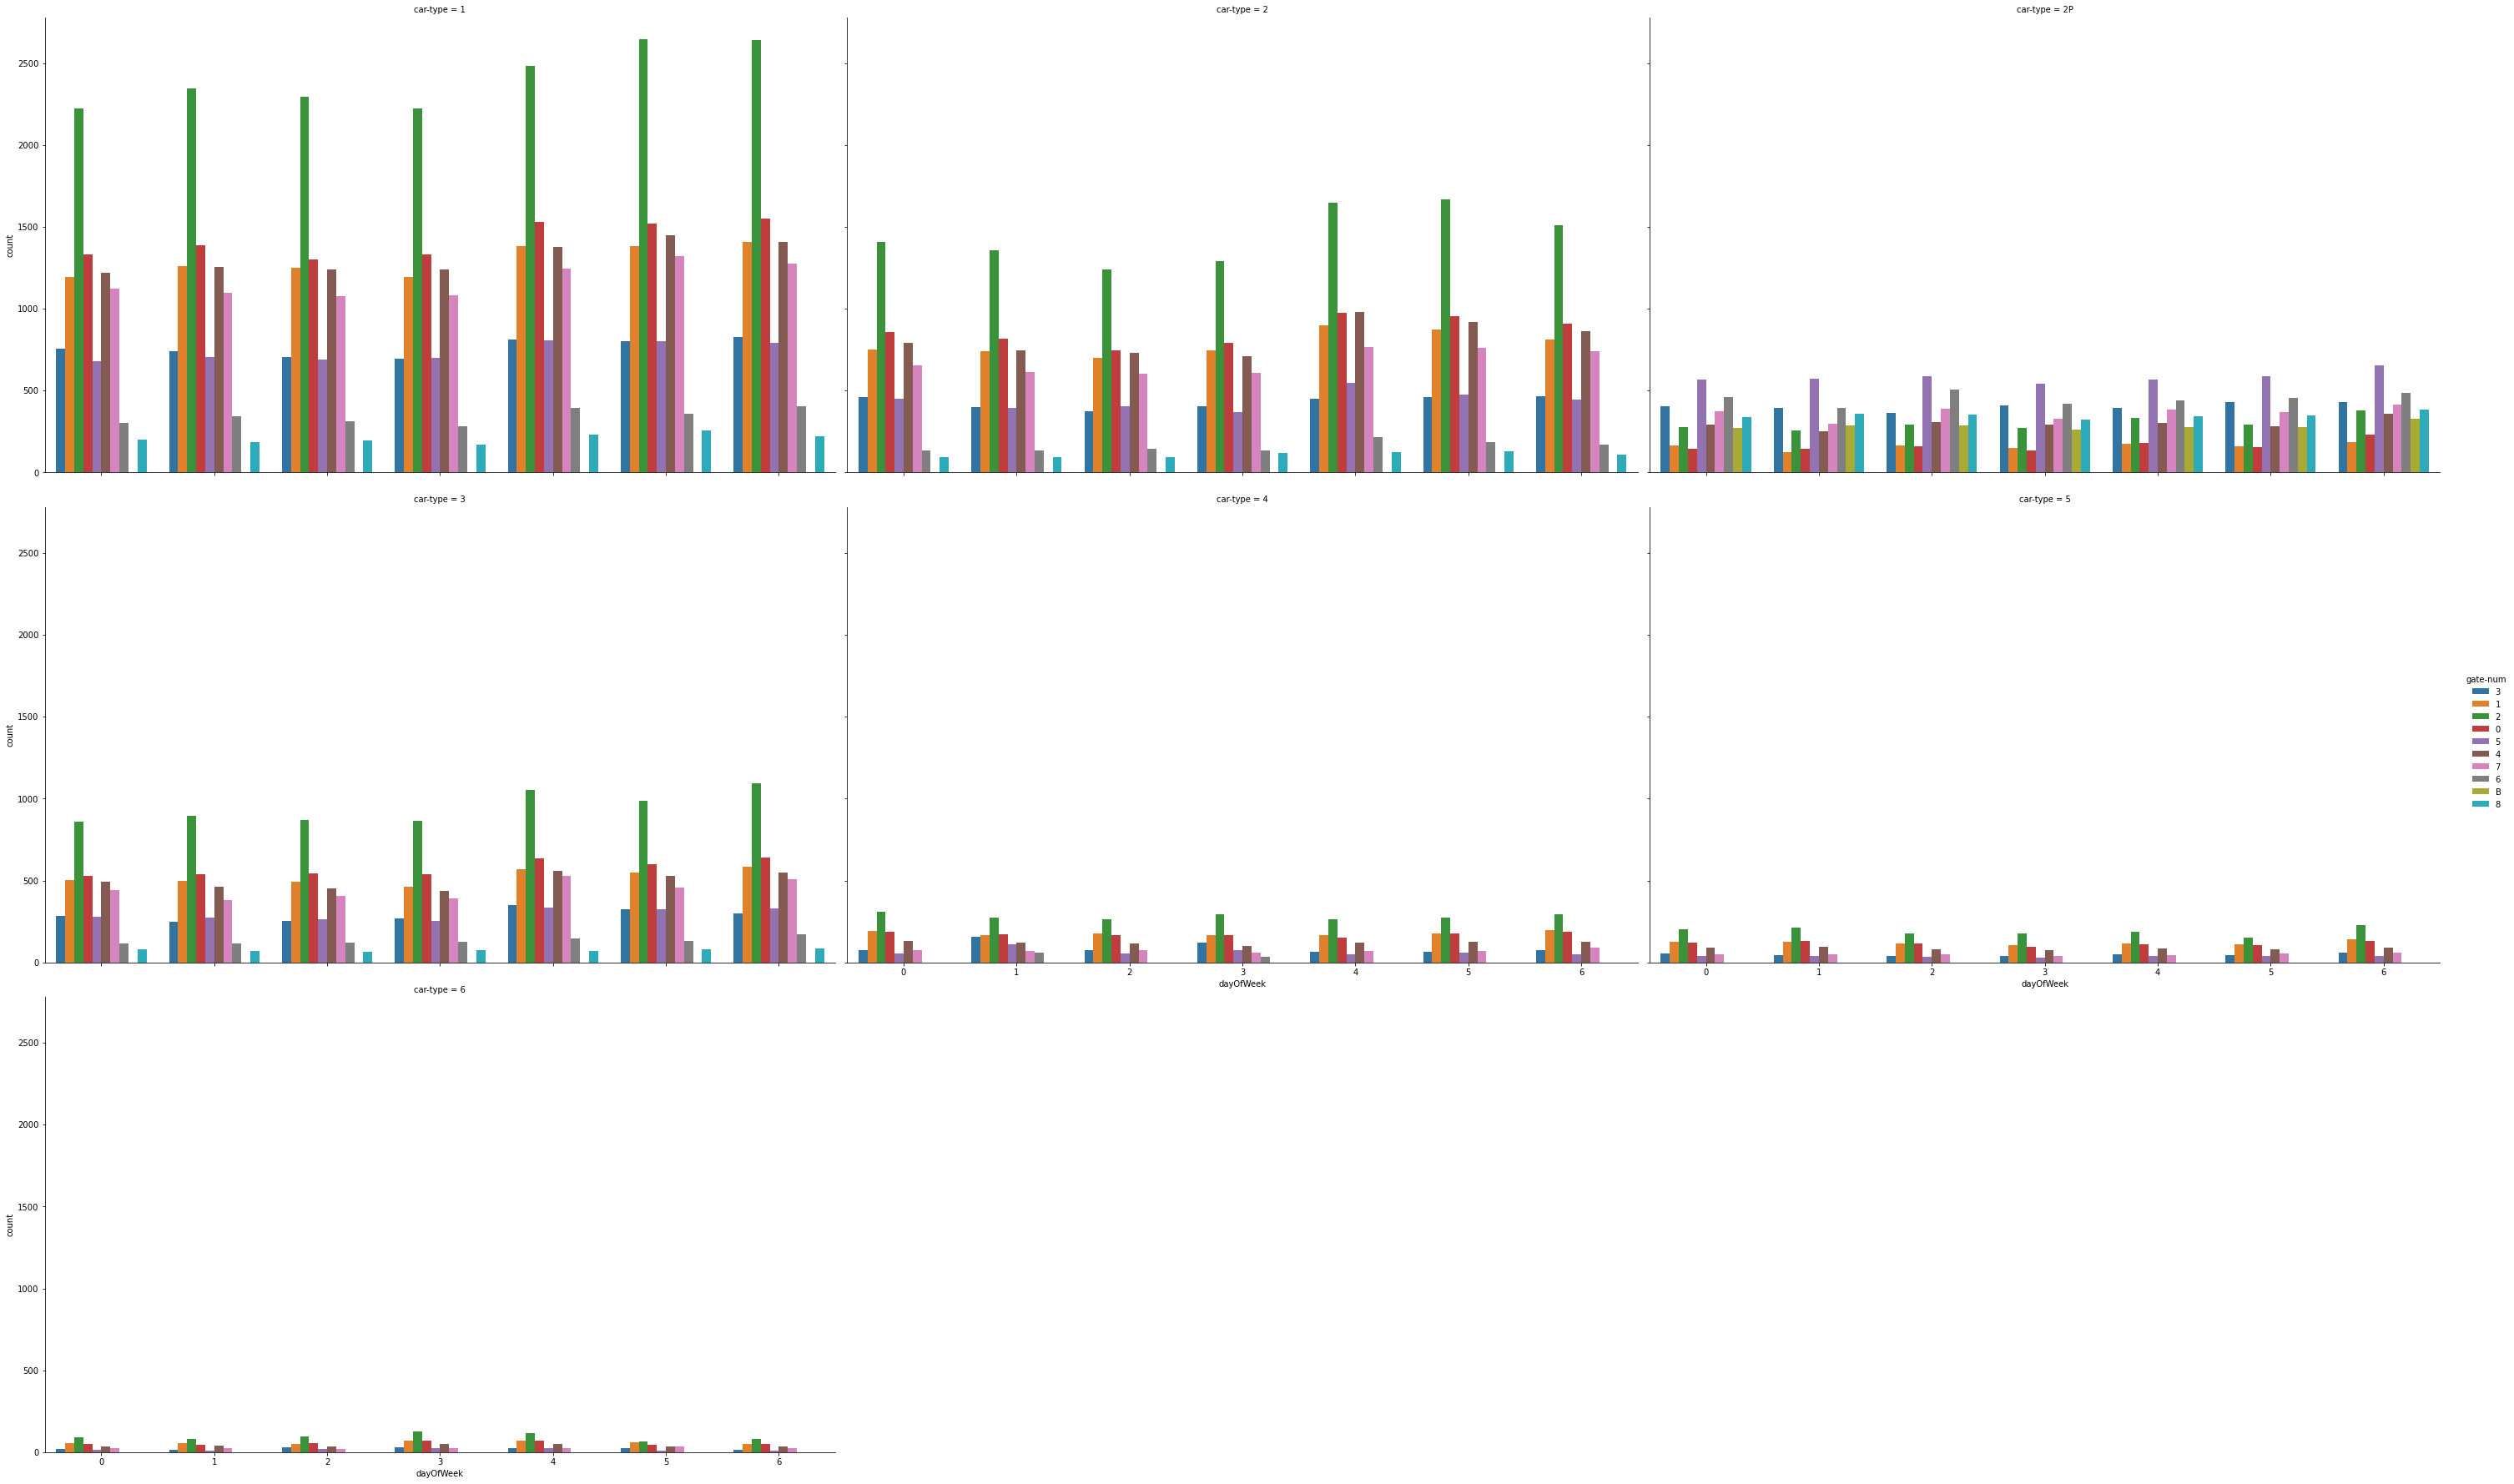

In [33]:
sns.catplot(data=path, x="dayOfWeek", hue="gate-num",col='car-type',kind="count" ,col_wrap=3,height=8.27, aspect=13.7/8.27)

Ranger Path

In [34]:
e=path[path['car-id']==(paths[paths['path']=='E -> General -> R -> R -> General -> E'].index)[0]]

print(f'how long it takes in minutes: {str(e.date.max() - e.date.min())}')

e

how long it takes in minutes: 0 days 00:46:01


,car-id,car-type,gate-name,date,day,dayOfWeek,Month,Year,Week,Time,gate-type,gate-num
Timestamp,,,,,,,,,,,,
2015-07-03 13:00:39,20150003010039-281,2,entrance3,2015-07-03 13:00:39,2015-07-03,4,7,2015,27,13:00:39,E,3
2015-07-03 13:19:46,20150003010039-281,2,general-gate1,2015-07-03 13:19:46,2015-07-03,4,7,2015,27,13:19:46,General,1
2015-07-03 13:22:13,20150003010039-281,2,ranger-stop2,2015-07-03 13:22:13,2015-07-03,4,7,2015,27,13:22:13,R,2
2015-07-03 13:25:03,20150003010039-281,2,ranger-stop0,2015-07-03 13:25:03,2015-07-03,4,7,2015,27,13:25:03,R,0
2015-07-03 13:28:03,20150003010039-281,2,general-gate2,2015-07-03 13:28:03,2015-07-03,4,7,2015,27,13:28:03,General,2
2015-07-03 13:46:40,20150003010039-281,2,entrance2,2015-07-03 13:46:40,2015-07-03,4,7,2015,27,13:46:40,E,2


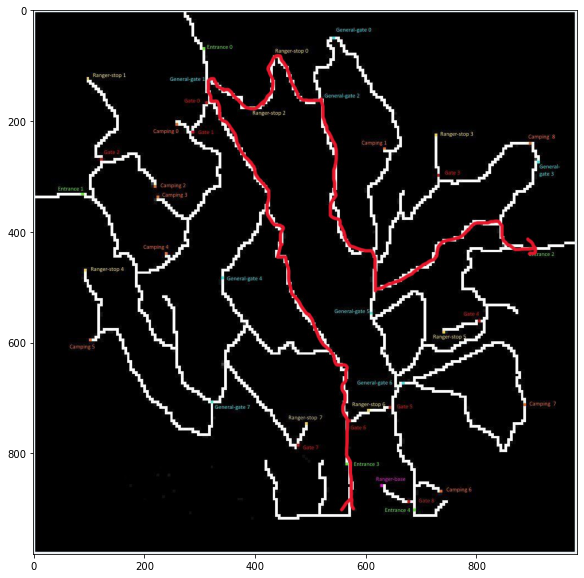

In [35]:
plt.figure(figsize=(10,10))
path1map=mpimg.imread('path1example.jpg')
maplot=plt.imshow(path1map)

In [36]:
e1=path[path['car-id']==(paths[paths['path']=='E -> General -> R -> R -> General -> E'].index)[3]]

print(f'how long it takes in minutes: {str(e1.date.max() - e1.date.min())}')

e1

how long it takes in minutes: 0 days 00:55:27


,car-id,car-type,gate-name,date,day,dayOfWeek,Month,Year,Week,Time,gate-type,gate-num
Timestamp,,,,,,,,,,,,
2015-07-07 00:00:29,20150007120029-935,1,entrance2,2015-07-07 00:00:29,2015-07-07,1,7,2015,28,00:00:29,E,2
2015-07-07 00:22:52,20150007120029-935,1,general-gate2,2015-07-07 00:22:52,2015-07-07,1,7,2015,28,00:22:52,General,2
2015-07-07 00:26:28,20150007120029-935,1,ranger-stop0,2015-07-07 00:26:28,2015-07-07,1,7,2015,28,00:26:28,R,0
2015-07-07 00:29:53,20150007120029-935,1,ranger-stop2,2015-07-07 00:29:53,2015-07-07,1,7,2015,28,00:29:53,R,2
2015-07-07 00:32:50,20150007120029-935,1,general-gate1,2015-07-07 00:32:50,2015-07-07,1,7,2015,28,00:32:50,General,1
2015-07-07 00:55:56,20150007120029-935,1,entrance3,2015-07-07 00:55:56,2015-07-07,1,7,2015,28,00:55:56,E,3


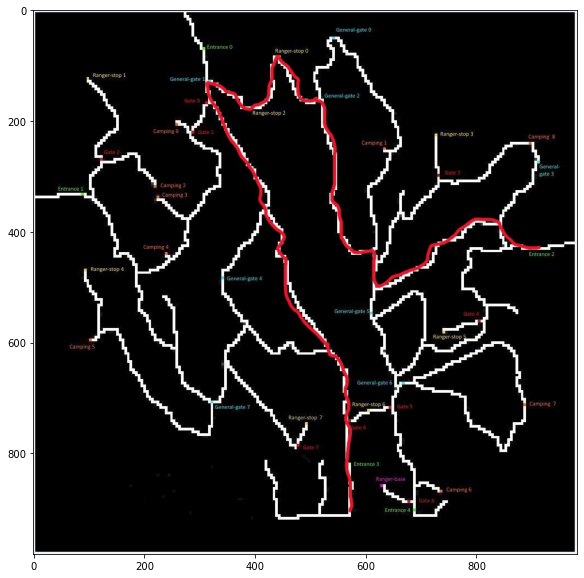

In [37]:
plt.figure(figsize=(10,10))
path1map=mpimg.imread('path1example1.jpg')
maplot=plt.imshow(path1map)

- car ID 20150007120029-935 and 20150003010039-281 are both passing through the same path using around 50 minutes.

In [38]:
e10=path[path['car-id']==(paths[paths['path']=='E -> General -> R -> R -> General -> E'].index)[1637]]

print(f'how long it takes in minutes: {str(e10.date.max() - e10.date.min())}')

e10

how long it takes in minutes: 0 days 00:31:47


,car-id,car-type,gate-name,date,day,dayOfWeek,Month,Year,Week,Time,gate-type,gate-num
Timestamp,,,,,,,,,,,,
2016-05-24 23:59:18,20165924115918-535,4,entrance0,2016-05-24 23:59:18,2016-05-24,1,5,2016,21,23:59:18,E,0
2016-05-25 00:00:51,20165924115918-535,4,general-gate1,2016-05-25 00:00:51,2016-05-25,2,5,2016,21,00:00:51,General,1
2016-05-25 00:03:36,20165924115918-535,4,ranger-stop2,2016-05-25 00:03:36,2016-05-25,2,5,2016,21,00:03:36,R,2
2016-05-25 00:06:48,20165924115918-535,4,ranger-stop0,2016-05-25 00:06:48,2016-05-25,2,5,2016,21,00:06:48,R,0
2016-05-25 00:10:10,20165924115918-535,4,general-gate2,2016-05-25 00:10:10,2016-05-25,2,5,2016,21,00:10:10,General,2
2016-05-25 00:31:05,20165924115918-535,4,entrance2,2016-05-25 00:31:05,2016-05-25,2,5,2016,21,00:31:05,E,2


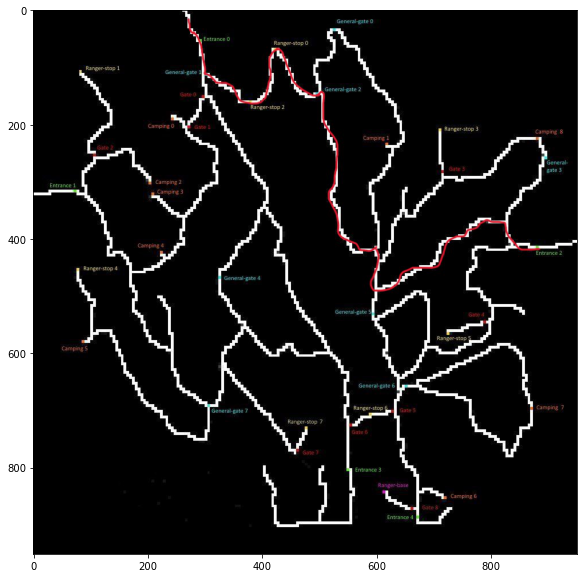

In [39]:
plt.figure(figsize=(10,10))
path1map=mpimg.imread('path1example2.jpg')
maplot=plt.imshow(path1map)

- an example that the ranger vehicle started before the end of the day and left the next day.

In [40]:
topPath1=path[path['car-id'].isin(paths[paths['path']=='E -> General -> R -> R -> General -> E'].index)].reset_index()
topPath1['car-id']=topPath1['car-id'].astype(str)
topPath1.head()

,Timestamp,car-id,car-type,gate-name,date,day,dayOfWeek,Month,Year,Week,Time,gate-type,gate-num
0,2015-05-01 10:36:32,20153601103632-930,3,entrance2,2015-05-01 10:36:32,2015-05-01,4,5,2015,18,10:36:32,E,2
1,2015-05-01 10:56:23,20153601103632-930,3,general-gate2,2015-05-01 10:56:23,2015-05-01,4,5,2015,18,10:56:23,General,2
2,2015-05-01 10:59:36,20153601103632-930,3,ranger-stop0,2015-05-01 10:59:36,2015-05-01,4,5,2015,18,10:59:36,R,0
3,2015-05-01 11:02:37,20153601103632-930,3,ranger-stop2,2015-05-01 11:02:37,2015-05-01,4,5,2015,18,11:02:37,R,2
4,2015-05-01 11:05:14,20153601103632-930,3,general-gate1,2015-05-01 11:05:14,2015-05-01,4,5,2015,18,11:05:14,General,1


In [41]:
timediff=topPath1.groupby('car-id')['date'].agg(['min','max']).reset_index()
timediff['diff(in min)']=timediff.apply(lambda x: int(((x['max']-x['min']).seconds // 60 % 60)), axis = 1)
timediff['diff(in days)']=timediff.apply(lambda x: int(((x['max']-x['min']).days)), axis = 1)
timediff['depart']=timediff['min'].dt.date
timediff.head(10)

,car-id,min,max,diff(in min),diff(in days),depart
0,20150003010039-281,2015-07-03 13:00:39,2015-07-03 13:46:40,46,0,2015-07-03
1,20150004110002-747,2015-08-04 11:00:02,2015-08-04 11:26:51,26,0,2015-08-04
2,20150006040002-269,2015-07-06 16:00:02,2015-07-06 16:33:43,33,0,2015-07-06
3,20150007120029-935,2015-07-07 00:00:29,2015-07-07 00:55:56,55,0,2015-07-07
4,20150013060021-372,2015-06-13 18:00:21,2015-06-13 18:30:08,29,0,2015-06-13
5,20150014010056-634,2015-09-14 01:00:56,2015-09-14 01:28:57,28,0,2015-09-14
6,20150017050047-192,2015-05-17 05:00:47,2015-05-17 05:34:59,34,0,2015-05-17
7,20150020070057-880,2015-07-20 19:00:57,2015-07-20 19:28:19,27,0,2015-07-20
8,20150021030032-233,2015-06-21 03:00:32,2015-06-21 03:33:12,32,0,2015-06-21
9,20150021110015-325,2015-11-21 11:00:15,2015-11-21 11:57:13,56,0,2015-11-21


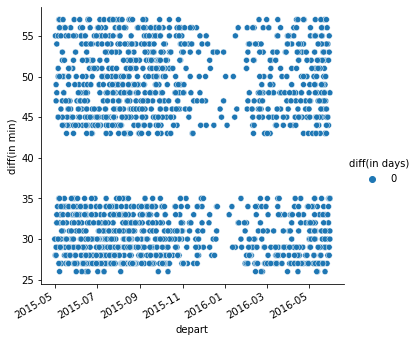

In [42]:
g=sns.relplot(x='depart',y='diff(in min)',hue='diff(in days)',data=timediff)
g.fig.autofmt_xdate()

- The ranger vehicles are likely driving the similar path with around 50 min and 30 min timeframe almost everyday.
- I would assume they either need to pass the ranger stop for shift switching or they need to perform small tasks at the ranger stops.
- There is a gap between January, a guess is it might due to the holiday at the end of the year.

2nd Path

In [43]:
path2Diff=path[path['car-id'].isin(paths[paths['path']=='E -> E'].index)].reset_index()
path2Diff['car-id']=path2Diff['car-id'].astype(str)
path2Diff=path2Diff.groupby('car-id')['date'].agg(['min','max']).reset_index()
path2Diff['diff(in min)']=path2Diff.apply(lambda x: int(((x['max']-x['min']).seconds // 60 % 60)), axis = 1)
path2Diff['diff(in days)']=path2Diff.apply(lambda x: int(((x['max']-x['min']).days)), axis = 1)
path2Diff['depart']=path2Diff['min'].dt.date
path2Diff.head(10)

,car-id,min,max,diff(in min),diff(in days),depart
0,20150004030033-995,2015-06-04 15:00:33,2015-06-04 15:22:48,22,0,2015-06-04
1,20150004050003-330,2015-08-04 05:00:03,2015-08-04 05:25:42,25,0,2015-08-04
2,20150006030042-85,2015-09-06 15:00:42,2015-09-06 15:23:04,22,0,2015-09-06
3,20150007060003-154,2015-05-07 18:00:03,2015-05-07 18:19:59,19,0,2015-05-07
4,20150010030024-367,2015-09-10 15:00:24,2015-09-10 15:21:03,20,0,2015-09-10
5,20150011060014-975,2015-09-11 18:00:14,2015-09-11 18:21:41,21,0,2015-09-11
6,20150012040030-974,2015-09-12 16:00:30,2015-09-12 16:21:59,21,0,2015-09-12
7,20150018030025-615,2015-05-18 03:00:25,2015-05-18 03:19:02,18,0,2015-05-18
8,20150024120054-586,2015-05-24 12:00:54,2015-05-24 12:20:07,19,0,2015-05-24
9,20150025070013-240,2015-08-25 19:00:13,2015-08-25 19:20:14,20,0,2015-08-25


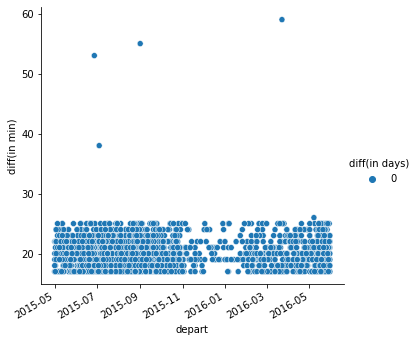

In [44]:
g2=sns.relplot(x='depart',y='diff(in min)',hue='diff(in days)',data=path2Diff)
g2.fig.autofmt_xdate()

In [45]:
e3=path[path['car-id']==(paths[paths['path']=='E -> E'].index)[0]]

print(f'how long it takes in minutes: {str(e3.date.max() - e3.date.min())}')

e3

how long it takes in minutes: 0 days 00:22:15


,car-id,car-type,gate-name,date,day,dayOfWeek,Month,Year,Week,Time,gate-type,gate-num
Timestamp,,,,,,,,,,,,
2015-06-04 15:00:33,20150004030033-995,5,entrance4,2015-06-04 15:00:33,2015-06-04,3,6,2015,23,15:00:33,E,4
2015-06-04 15:22:48,20150004030033-995,5,entrance2,2015-06-04 15:22:48,2015-06-04,3,6,2015,23,15:22:48,E,2


In [46]:
e4=path[path['car-id']==(paths[paths['path']=='E -> E'].index)[1]]

print(f'how long it takes in minutes: {str(e4.date.max() - e4.date.min())}')

e4

how long it takes in minutes: 0 days 00:25:39


,car-id,car-type,gate-name,date,day,dayOfWeek,Month,Year,Week,Time,gate-type,gate-num
Timestamp,,,,,,,,,,,,
2015-08-04 05:00:03,20150004050003-330,1,entrance3,2015-08-04 05:00:03,2015-08-04,1,8,2015,32,05:00:03,E,3
2015-08-04 05:25:42,20150004050003-330,1,entrance0,2015-08-04 05:25:42,2015-08-04,1,8,2015,32,05:25:42,E,0


In [47]:
e5=path[path['car-id']==(paths[paths['path']=='E -> E'].index)[110]]

print(f'how long it takes in minutes: {str(e5.date.max() - e5.date.min())}')

e5

how long it takes in minutes: 0 days 00:23:16


,car-id,car-type,gate-name,date,day,dayOfWeek,Month,Year,Week,Time,gate-type,gate-num
Timestamp,,,,,,,,,,,,
2015-06-11 17:06:45,20150611050645-707,1,entrance0,2015-06-11 17:06:45,2015-06-11,3,6,2015,24,17:06:45,E,0
2015-06-11 17:30:01,20150611050645-707,1,entrance3,2015-06-11 17:30:01,2015-06-11,3,6,2015,24,17:30:01,E,3


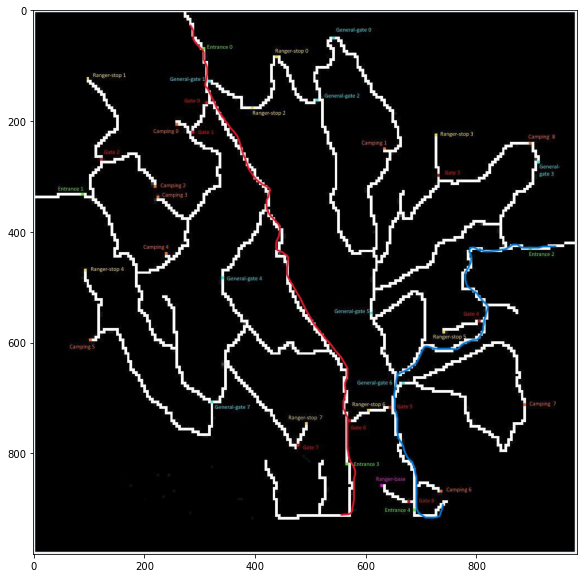

In [48]:
plt.figure(figsize=(10,10))
path1map=mpimg.imread('path1example3.jpg')
maplot=plt.imshow(path1map)

- It's likely people were passing by the park, or may be just check the view of the park.

3rd Path

In [49]:
e6=path[path['car-id']==(paths[paths['path']=='E -> General -> C -> C -> General -> E'].index)[0]]

print(f'how long it takes: {str(e6.date.max() - e6.date.min())}')

e6

how long it takes: 4 days 00:53:05


,car-id,car-type,gate-name,date,day,dayOfWeek,Month,Year,Week,Time,gate-type,gate-num
Timestamp,,,,,,,,,,,,
2015-09-01 17:00:42,20150001050042-811,1,entrance2,2015-09-01 17:00:42,2015-09-01,1,9,2015,36,17:00:42,E,2
2015-09-01 17:16:30,20150001050042-811,1,general-gate6,2015-09-01 17:16:30,2015-09-01,1,9,2015,36,17:16:30,General,6
2015-09-01 17:26:30,20150001050042-811,1,camping7,2015-09-01 17:26:30,2015-09-01,1,9,2015,36,17:26:30,C,7
2015-09-05 17:36:19,20150001050042-811,1,camping7,2015-09-05 17:36:19,2015-09-05,5,9,2015,36,17:36:19,C,7
2015-09-05 17:46:13,20150001050042-811,1,general-gate6,2015-09-05 17:46:13,2015-09-05,5,9,2015,36,17:46:13,General,6
2015-09-05 17:53:47,20150001050042-811,1,entrance4,2015-09-05 17:53:47,2015-09-05,5,9,2015,36,17:53:47,E,4


In [50]:
e7=path[path['car-id']==(paths[paths['path']=='E -> General -> C -> C -> General -> E'].index)[7]]

print(f'how long it takes: {str(e7.date.max() - e7.date.min())}')

e7

how long it takes: 1 days 06:21:42


,car-id,car-type,gate-name,date,day,dayOfWeek,Month,Year,Week,Time,gate-type,gate-num
Timestamp,,,,,,,,,,,,
2015-06-13 11:00:26,20150013110026-797,1,entrance3,2015-06-13 11:00:26,2015-06-13,5,6,2015,24,11:00:26,E,3
2015-06-13 11:14:09,20150013110026-797,1,general-gate7,2015-06-13 11:14:09,2015-06-13,5,6,2015,24,11:14:09,General,7
2015-06-13 11:23:27,20150013110026-797,1,camping5,2015-06-13 11:23:27,2015-06-13,5,6,2015,24,11:23:27,C,5
2015-06-14 16:59:12,20150013110026-797,1,camping5,2015-06-14 16:59:12,2015-06-14,6,6,2015,24,16:59:12,C,5
2015-06-14 17:08:27,20150013110026-797,1,general-gate7,2015-06-14 17:08:27,2015-06-14,6,6,2015,24,17:08:27,General,7
2015-06-14 17:22:08,20150013110026-797,1,entrance3,2015-06-14 17:22:08,2015-06-14,6,6,2015,24,17:22:08,E,3


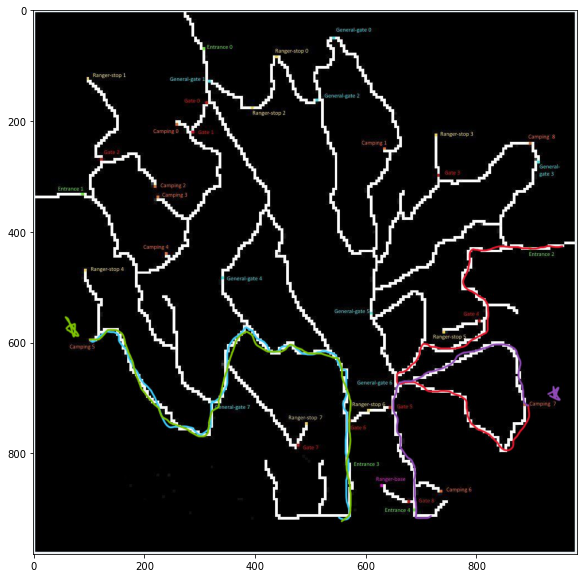

In [51]:
plt.figure(figsize=(10,10))
path3map=mpimg.imread('path3examples.jpg')
maplot=plt.imshow(path3map)

In [52]:
topPath3=path[path['car-id'].isin(paths[paths['path']=='E -> General -> C -> C -> General -> E'].index)].reset_index()
topPath3['car-id']=topPath3['car-id'].astype(str)
campdiff=topPath3.groupby('car-id')['date'].agg(['min','max']).reset_index()
campdiff['diff(in days)']=campdiff.apply(lambda x: int(((x['max']-x['min']).days)), axis = 1)
campdiff.head(10)

,car-id,min,max,diff(in days)
0,20150001050042-811,2015-09-01 17:00:42,2015-09-05 17:53:47,4
1,20150006070008-822,2015-07-06 07:00:08,2015-07-06 10:22:44,0
2,20150006080007-531,2015-08-06 08:00:07,2015-08-11 19:32:45,5
3,20150010020057-694,2015-07-10 14:00:57,2015-07-16 15:33:21,6
4,20150010040037-125,2015-07-10 16:00:37,2015-07-11 19:31:09,1
5,20150010120037-8,2015-07-10 12:00:37,2015-07-23 13:06:31,13
6,20150011120023-724,2015-07-11 12:00:23,2015-07-13 17:31:06,2
7,20150013110026-797,2015-06-13 11:00:26,2015-06-14 17:22:08,1
8,20150016070028-165,2015-07-16 07:00:28,2015-07-16 12:22:02,0
9,20150016070034-393,2015-06-16 07:00:34,2015-06-16 12:23:21,0


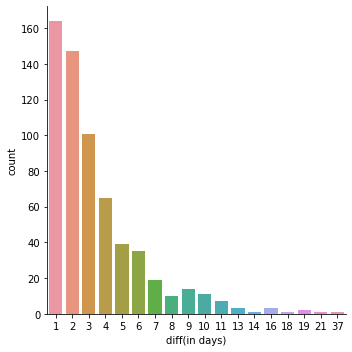

In [53]:
campdiff=campdiff[campdiff['diff(in days)']>0]

sns.catplot(data=campdiff, x="diff(in days)",kind="count")


- The plot is right skewed which indicates campers are most likely stay less days than long days.

#### Modeling

Decomposing the date

In [54]:
ts=df.groupby(['day']).agg({'car-id':'nunique'}).reset_index().rename(columns={'car-id': 'Volume'})
ts['day']=pd.to_datetime(ts['day'])
ts = ts.set_index('day')


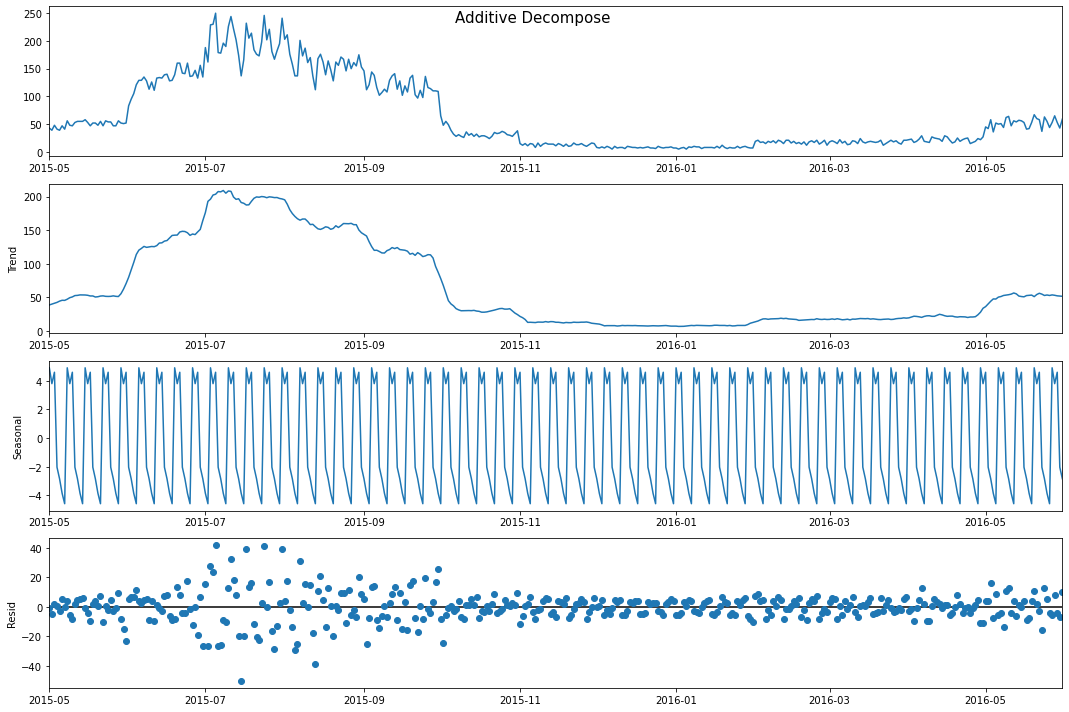

In [55]:
decompose = sm.tsa.seasonal_decompose(ts, model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (15,10)})
decompose.plot().suptitle('Additive Decompose', fontsize=15)
plt.show()

SARIMAX forecasting - ARIMA

In [56]:
ts

,Volume
day,
2015-05-01,43
2015-05-02,39
2015-05-03,48
2015-05-04,41
2015-05-05,39
...,...
2016-05-27,53
2016-05-28,65
2016-05-29,53


Training dataset spliting

In [57]:
train = ts.loc['2015-05-01':'2016-05-15']

In [58]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

pdq_cand = [(x[0], x[1], x[2], 12)
                for x in list(itertools.product(p, d, q))]

print('Examples of parameter candidates for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], pdq_cand[1]))
print('SARIMAX: {} x {}'.format(pdq[1], pdq_cand[2]))
print('SARIMAX: {} x {}'.format(pdq[2], pdq_cand[3]))

Examples of parameter candidates for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)


In [59]:
## parameters selection
d={'candidates':[],
   'seasonal_candidate':[],
   'aic':[]}
cand = pd.DataFrame(d)

for param in pdq:
    for param_seasonal in pdq_cand:
        mod = sm.tsa.statespace.SARIMAX(train,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        cand.loc[len(cand.index)] = [param,param_seasonal, results.aic]


        

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92926D+00    |proj g|=  2.22650D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   4.885D-09   5.929D+00
  F =   5.9292569128468688     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.5

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  5.29217D+00    |proj g|=  3.41476D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     25      1     0     0   2.442D-06   5.292D+00
  F =   5.2921684294766740     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64917D+00    |proj g|=  1.15011D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/minic

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64850D+00    |proj g|=  4.87810D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   4.870D-05   4.649D+00
  F =   4.6485015352493120     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.8

 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.69831D+00    |proj g|=  1.02423D+00

At iterate    5    f=  4.50715D+00    |proj g|=  2.45516D-01

At iterate   10    f=  4.49281D+00    |proj g|=  4.14067D-03

At iterate   15    f=  4.48986D+00    |proj g|=  3.31152D-02

At iterate   20    f=  4.48956D+00    |proj g|=  3.00690D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     28      1     0     0   3.007D-05   4.490D+00
  F =   4.4895570744175277     

CONVERG

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.58761D+00    |proj g|=  1.43189D-01

At iterate    5    f=  5.57684D+00    |proj g|=  7.27908D-03

At iterate   10    f=  5.56308D+00    |proj g|=  1.75336D-01

At iterate   15    f=  5.38272D+00    |proj g|=  4.17596D-01

At iterate   20    f=  5.35499D+00    |proj g|=  4.02245D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     21     29      1     0     0   4.678D-06   5.355D+00
  F =   5.3549861951048285     

CONVERG

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.25723D+00    |proj g|=  3.93650D-02

At iterate   10    f=  4.24741D+00    |proj g|=  1.65702D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   1.940D-07   4.247D+00
  F =   4.2474065789995885     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.30191D+00    |proj g|=  3.38484D-02

At iterate    5    f=  5.27706D+00    |proj g|=  9.10006D-02


/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  4.52209D+00    |proj g|=  5.35768D-01

At iterate   15    f=  4.38615D+00    |proj g|=  3.96230D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     33      1     0     0   6.024D-06   4.386D+00
  F =   4.3857355123288171     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28269D+00    |proj g|=  5.34582D-02

At iterate    5    f=  5.26554D+00    |proj g|=  1.93263D-02

At iter

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.28257D+00    |proj g|=  7.88417D-03

At iterate   10    f=  4.27211D+00    |proj g|=  6.52929D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   8.853D-06   4.269D+00
  F =   4.2693035846844865     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32630D+00    |proj g|=  2.99212D-01


/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.25933D+00    |proj g|=  2.42327D-02

At iterate   10    f=  4.24770D+00    |proj g|=  4.10034D-02

At iterate   15    f=  4.23844D+00    |proj g|=  7.66582D-02

At iterate   20    f=  4.23681D+00    |proj g|=  3.96300D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     24      1     0     0   3.963D-05   4.237D+00
  F =   4.2368090289881266     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iter

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/minic

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.25681D+00    |proj g|=  1.85858D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   1.536D-06   4.256D+00
  F =   4.2564705531896534     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.9

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/minic


At iterate    5    f=  3.94219D+00    |proj g|=  1.77096D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     19      1     0     0   5.842D-07   3.942D+00
  F =   3.9420176039794175     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.08287D+00    |proj g|=  5.23421D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.90829D+00    |proj g|=  1.68746D-02

At iterate   10    f=  3.90296D+00    |proj g|=  1.81197D-01

At iterate   15    f=  3.87135D+00    |proj g|=  5.34140D-02

At iterate   20    f=  3.87111D+00    |proj g|=  2.58908D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred fre


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     38      1     0     0   2.589D-05   3.871D+00
  F =   3.8711116981345737     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02701D+00    |proj g|=  3.64137D-02

At iterate    5    f=  4.02601D+00    |proj g|=  2.44580D-03

At iterate   10    f=  4.02597D+00    |proj g|=  1.78906D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.23806D+00    |proj g|=  9.08236D-03

At iterate    5    f=  4.23800D+00    |proj g|=  9.48788D-04

At iterate   10    f=  4.23799D+00    |proj g|=  8.21121D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     12      1     0     0   8.211D-07   4.238D+00
  F =   4.2379914871693378     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91272D+00    |proj g|=  3.88942D-02

At iterate    5    f=  3.90961D+00    |proj g|=  2.57489D-02

At iterate   10    f=  3.90610D+00    |proj g|=  2.27275D-03

At iterate   15    f=  3.90601D+00    |proj g|=  5.54321D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   2.940D-06   3.906D+00
  F =   3.9059921320183233     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96211D+00    |proj g|=  1.70289D-01

At iterate    5    f=  3.90407D+00    |proj g|=  8.43185D-02

At iterate   10    f=  3.83312D+00    |proj g|=  2.07413D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     23      1     0     0   1.739D-04   3.833D+00
  F =   3.8330450373413463     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred fre

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07595D+00    |proj g|=  2.04953D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   2.049D-04   4.076D+00
  F =   4.0759497336526795     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.9


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00638D+00    |proj g|=  2.85488D-01

At iterate    5    f=  3.92192D+00    |proj g|=  1.14841D-01

At iterate   10    f=  3.87823D+00    |proj g|=  2.39265D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     23      1     0     0   1.013D-04   3.876D+00
  F =   3.8756918356478693     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.34481D+00    |proj g|=  8.70681D-01

At iterate    5    f=  3.95944D+00    |proj g|=  3.75428D-01

At iterate   10    f=  3.95733D+00    |proj g|=  4.19554D-03

At iterate   15    f=  3.95730D+00    |proj g|=  5.29666D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     23      1     0     0   1.394D-05   3.957D+00
  F =   3.9572974211069081     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00305D+00    |proj g|=  3.09896D-01

At iterate    5    f=  3.92196D+00    |proj g|=  1.35388D-01

At iterate   10    f=  3.92027D+00    |proj g|=  9.91436D-02

At iterate   15    f=  3.89319D+00    |proj g|=  2.08078D-01

At iterate   20    f=  3.87596D+00    |proj g|=  9.03140D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     37      1     0     0   6.148D-06   3.876D+00
  F =   3.8756483792255794     

CONVERG

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03547D+00    |proj g|=  3.33104D-02

At iterate    5    f=  4.03464D+00    |proj g|=  9.04669D-04

At iterate   10    f=  4.03463D+00    |proj g|=  2.50774D-02

At iterate   15    f=  4.03460D+00    |proj g|=  1.09423D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     25      1     0     0   1.294D-05   4.035D+00
  F =   4.0345992589270967     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.89821D+00    |proj g|=  2.83977D-02

At iterate   10    f=  3.89494D+00    |proj g|=  7.10268D-02

At iterate   15    f=  3.85130D+00    |proj g|=  3.58305D-01

At iterate   20    f=  3.84041D+00    |proj g|=  7.18347D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     27      1     0     0   9.386D-06   3.840D+00
  F =   3.8404084345615597     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.95277D+00    |proj g|=  1.85594D-01

At iterate   10    f=  3.92883D+00    |proj g|=  1.05222D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   1.383D-05   3.929D+00
  F =   3.9288315453720992     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09206D+00    |proj g|=  6.30401D-01

At iterate    5    f=  3.91764D+00    |proj g|=  6.84677D-02

At iter

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  4.03600D+00    |proj g|=  1.52585D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   1.470D-05   4.036D+00
  F =   4.0358647028421286     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.99197D+00    |proj g|=  3.08941D-01


/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.90369D+00    |proj g|=  1.76005D-01

At iterate   10    f=  3.89634D+00    |proj g|=  8.70661D-02

At iterate   15    f=  3.89451D+00    |proj g|=  1.04421D-01

At iterate   20    f=  3.85696D+00    |proj g|=  4.80636D-01

At iterate   25    f=  3.84049D+00    |proj g|=  8.97223D-03

At iterate   30    f=  3.84041D+00    |proj g|=  6.80095D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     43      1     0     0   5.448D-05   3.840D+00
  F =   3.8404082413078071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/minic

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03881D+00    |proj g|=  5.29017D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.290D-06   4.039D+00
  F =   4.0388082278003852     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.9

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.92229D+00    |proj g|=  3.26850D-02

At iterate   10    f=  3.91950D+00    |proj g|=  1.04589D-03

At iterate   15    f=  3.91944D+00    |proj g|=  3.35531D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   2.632D-06   3.919D+00
  F =   3.9194346657722763     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06306D+00    |proj g|=  3.86482D-02


/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate    5    f=  4.06100D+00    |proj g|=  2.84915D-02

At iterate   10    f=  4.05928D+00    |proj g|=  3.80238D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   3.802D-06   4.059D+00
  F =   4.0592806209381047     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.97259D+00    |proj g|=  1.70785D-01


 This problem is unconstrained.



At iterate    5    f=  3.92058D+00    |proj g|=  2.10376D-02

At iterate   10    f=  3.89925D+00    |proj g|=  2.21795D-01

At iterate   15    f=  3.85684D+00    |proj g|=  1.20303D-01

At iterate   20    f=  3.84556D+00    |proj g|=  1.23610D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     34      1     0     0   4.030D-06   3.846D+00
  F =   3.8455584960995792     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.91426D+00    |proj g|=  2.58199D-03

At iterate   10    f=  3.91401D+00    |proj g|=  1.10051D-02

At iterate   15    f=  3.91340D+00    |proj g|=  2.86689D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   5.020D-07   3.913D+00
  F =   3.9133876086581045     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.21981D+00    |proj g|=  1.73174D-01


/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.19007D+00    |proj g|=  5.93951D-02

At iterate   10    f=  4.18982D+00    |proj g|=  2.24631D-02

At iterate   15    f=  4.18735D+00    |proj g|=  3.88844D-02

At iterate   20    f=  4.18728D+00    |proj g|=  3.33131D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     27      1     0     0   3.331D-05   4.187D+00
  F =   4.1872828778917466     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *



/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94243D+00    |proj g|=  1.72123D-01

At iterate    5    f=  3.89845D+00    |proj g|=  2.18103D-02

At iterate   10    f=  3.87278D+00    |proj g|=  1.36403D-01

At iterate   15    f=  3.81759D+00    |proj g|=  4.77479D-02

At iterate   20    f=  3.81611D+00    |proj g|=  7.15785D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     24      1     0     0   7.158D-05   3.816D+00
  F =   3.8161112471473064     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH     

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  3.92312D+00    |proj g|=  1.09702D-02

At iterate   20    f=  3.92283D+00    |proj g|=  1.56436D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   2.133D-06   3.923D+00
  F =   3.9228346221545132     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91487D+00    |proj g|=  4.52310D-02

At iterate    5    f=  3.91262D+00    |proj g|=  4.27173D-02

At iter

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.02279D+00    |proj g|=  7.57884D-02

At iterate   10    f=  4.02130D+00    |proj g|=  2.05207D-02

At iterate   15    f=  4.01302D+00    |proj g|=  1.83294D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   4.502D-06   4.013D+00
  F =   4.0128132774000287     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95242D+00    |proj g|=  1.59650D-01

At iterate    5    f=  3.89901D+00    |proj g|=  7.17835D-02

At iterate   10    f=  3.89720D+00    |proj g|=  4.31447D-02

At iterate   15    f=  3.84079D+00    |proj g|=  2.03630D-01

At iterate   20    f=  3.83493D+00    |proj g|=  3.12112D-03

At iterate   25    f=  3.83473D+00    |proj g|=  2.63695D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   

In [73]:
cand

,candidates,seasonal_candidate,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",4520.093768
1,"(0, 0, 0)","(0, 0, 1, 12)",4036.632343
2,"(0, 0, 0)","(0, 1, 0, 12)",3544.448307
3,"(0, 0, 0)","(0, 1, 1, 12)",3441.801206
4,"(0, 0, 0)","(1, 0, 0, 12)",3546.158170
...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 12)",2915.876770
60,"(1, 1, 1)","(1, 0, 0, 12)",2997.199982
61,"(1, 1, 1)","(1, 0, 1, 12)",2971.541445
62,"(1, 1, 1)","(1, 1, 0, 12)",3065.763717


In [61]:
# find lowest AIC
cand[cand.aic==cand['aic'].min()]

,candidates,seasonal_candidate,aic
59,"(1, 1, 1)","(0, 1, 1, 12)",2915.87677


In [62]:
#model fitting

arima = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=False).fit()

print(arima.summary())

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09358D+00    |proj g|=  1.58558D-01

At iterate    5    f=  4.05214D+00    |proj g|=  2.80054D-02

At iterate   10    f=  3.98559D+00    |proj g|=  2.54698D-02

At iterate   15    f=  3.98162D+00    |proj g|=  1.60782D-02

At iterate   20    f=  3.98000D+00    |proj g|=  2.39700D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     33      1     0     0   8.001D-06   3.980D+00
  F =   3.9799842790711941     

CONVERG

Observations:
- Dependent variable is the car volume.
- the p value for Ljung-box is above 0.05, we can't reject the null that the errors are white noise.
- the p value for heteroscedasticity is above 0.05, indicating our error residuals have the same variance.

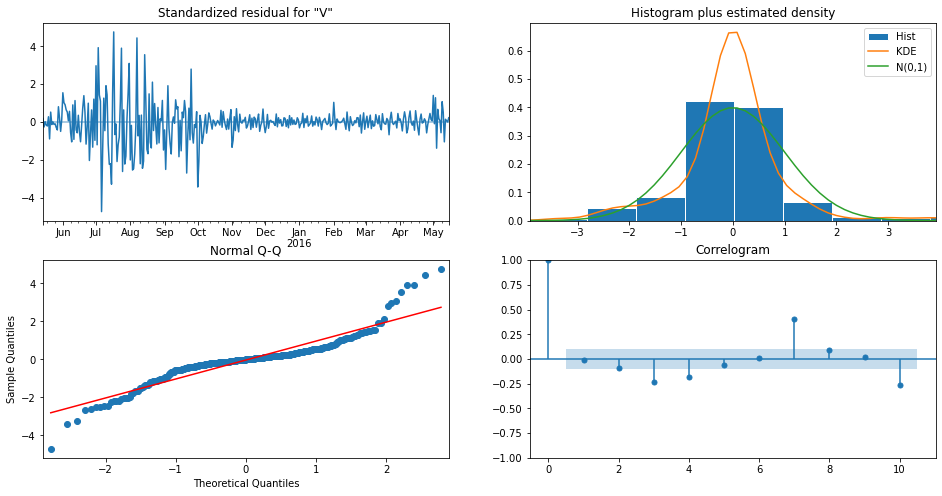

In [63]:
arima.plot_diagnostics(figsize=(16, 8))
plt.show()

- Residuals are spread from May to Oct.

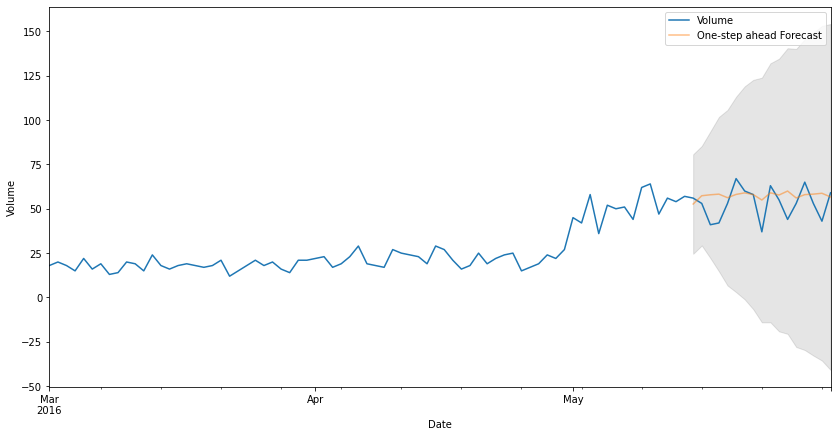

In [64]:
pred = arima.get_prediction(
    start=pd.to_datetime('2016-05-15'),end=pd.to_datetime('2016-05-31'))

pred_ci = pred.conf_int()

ax = ts['2016-03-01':'2016-05-31'].plot(label='observed')

pred.predicted_mean.plot(
    ax=ax, label='One-step ahead Forecast', alpha=.5, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Volume')

plt.legend()
plt.show()

In [65]:
ARIMA_MAE = mean_absolute_error(ts.loc['2016-05-15':'2016-05-31'], pred.predicted_mean)
ARIMA_MSE = mean_squared_error(ts.loc['2016-05-15':'2016-05-31'], pred.predicted_mean)
print(f'ARIMA MAE: {ARIMA_MAE}')
print(f'ARIMA MSE: {ARIMA_MSE}')

ARIMA MAE: 7.535951944603401
ARIMA MSE: 94.71947820725998


Prophet model

In [66]:
train=train.reset_index(level=0)
train=train.rename(columns={'day': 'ds', 'Volume': 'y'})

In [67]:
prop = prophet.Prophet(interval_width = 0.90, seasonality_mode = 'additive').fit(train)

20:25:04 - cmdstanpy - INFO - Chain [1] start processing
20:25:04 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
predDF=prop.make_future_dataframe(periods=16, freq='D')
predDF.tail()

,ds
392,2016-05-27
393,2016-05-28
394,2016-05-29
395,2016-05-30
396,2016-05-31


In [69]:
predProp = prop.predict(predDF)

predProp[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
392,2016-05-27,41.919533,13.793515,68.586764
393,2016-05-28,40.919748,12.533785,66.598963
394,2016-05-29,42.220740,13.736400,69.936053
395,2016-05-30,35.740823,5.930910,63.489746
396,2016-05-31,34.559633,7.154694,62.869403


- a column yhat represents the prediction, awa boundry cols.

In [70]:
re=predProp[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

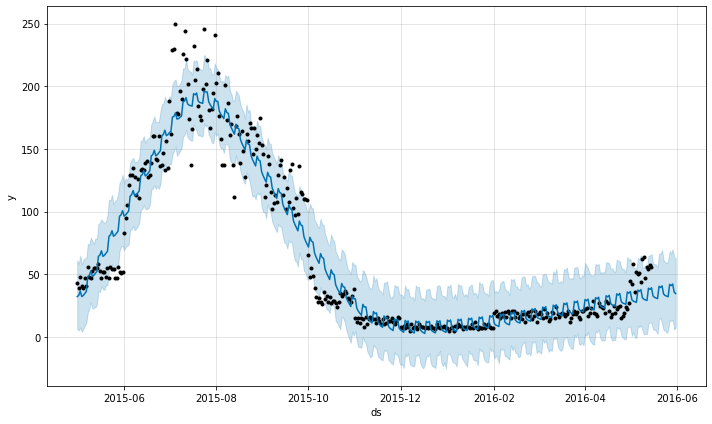

In [71]:
prop.plot(predProp);

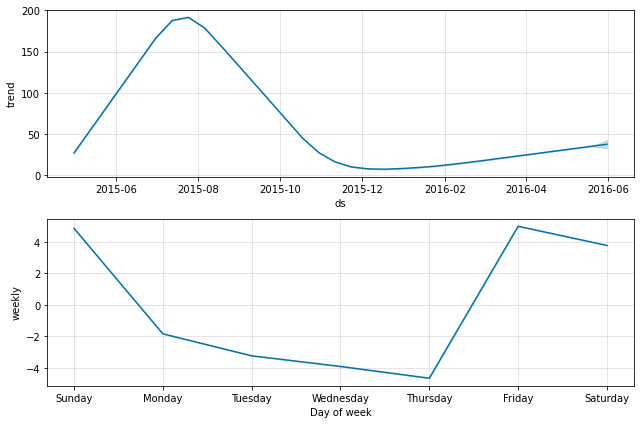

In [72]:
prop.plot_components(predProp);

- The first plot illustrates a consistent linear increase in car volume on a yearly basis, starting from May and gradually decreasing from August onwards.
- In the second plot, it is evident that the weekly car volume typically reaches its peak during the period from Friday to Sunday.

In [82]:
prop_MAE = mean_absolute_error(ts.reset_index().Volume, re.yhat)
prop_MSE = mean_squared_error(ts.reset_index().Volume, re.yhat)
print(f'Prophet MAE: {prop_MAE}')
print(f'Prophet MSE: {prop_MAE}')

Prophet MAE: 11.79126512707637
Prophet MSE: 11.79126512707637
